In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable

torch.manual_seed(0)

In [2]:
# Keep results
RMSE=list()
MPE=list()

In [3]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData.csv')

#Scale Cell life target Values
Dataset['cell_life']=np.log10(Dataset['cell_life'])

numBat1=41
numBat2=43
numBat3=40
numBat=124
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
test_edited_ind = np.delete(test_ind, 21) # Remove battery 
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat)

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']

In [4]:
#Load discharge capacity data
train_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Train.pt')
test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Test.pt')
secondary_test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Secondary_Test.pt')

train_Qdlin = torch.permute(train_Qdlin, (0, 2, 1))
test_Qdlin = torch.permute(test_Qdlin, (0, 2, 1))
secondary_test_Qdlin = torch.permute(secondary_test_Qdlin, (0, 2, 1))

print(train_Qdlin.std(),train_Qdlin.mean())
print(test_Qdlin.std(),test_Qdlin.mean())
print(secondary_test_Qdlin.std(),secondary_test_Qdlin.mean())

print(train_Qdlin.shape)
print(test_Qdlin.shape)
print(secondary_test_Qdlin.shape)

tensor(1.0000, dtype=torch.float64) tensor(-0.6982, dtype=torch.float64)
tensor(0.8786, dtype=torch.float64) tensor(-0.6188, dtype=torch.float64)
tensor(0.4862, dtype=torch.float64) tensor(-0.3183, dtype=torch.float64)
torch.Size([41, 99, 100])
torch.Size([42, 99, 100])
torch.Size([40, 99, 100])


In [5]:
y_train=Training_Data[target_features].to_numpy()
y_test=Testing_Data[target_features].to_numpy()
y_sec=Secondary_Data[target_features].to_numpy()

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_sec = torch.tensor(y_sec)

y_train_mean = torch.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean
y_sec = y_sec - y_train_mean
#Be sure to add y_train_mean and 10** All results

In [6]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
  
    def __len__(self):
        return len(self.features)

In [7]:
class LSTMRNN(nn.Module):

    def __init__(self, input_size, hidden_size, hidden_size2, num_layers,
                 dropout, num_dense_neurons):
        
        super(LSTMRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.num_layers = num_layers
        self.dropout = dropout
        self.num_dense_neurons = num_dense_neurons
        self.firstEpochFlag = True
        
        self.dropout_layer = nn.Dropout(self.dropout)
        
        self.lstm = nn.LSTM(input_size = self.input_size,
                            hidden_size = self.hidden_size,
                            num_layers = self.num_layers,
#                             dropout = self.dropout,
                            batch_first = True)
        
        self.lstm2 = nn.LSTM(input_size = self.hidden_size,
                            hidden_size = self.hidden_size2,
                            num_layers = self.num_layers,
#                             dropout = self.dropout,
                            batch_first = True)
        
        self.linear_layer = nn.Sequential(
            #nn.Dropout(self.dropout)
            nn.Linear(self.hidden_size2, self.num_dense_neurons),
            nn.ReLU(),
            nn.Linear(num_dense_neurons,1),
        )
  
    def forward(self, x):
        if(self.firstEpochFlag):print(x.shape)
        h0 = Variable(torch.zeros(self.num_layers, x.shape[0], self.hidden_size,device=x.device))
        c0 = Variable(torch.zeros(self.num_layers, x.shape[0], self.hidden_size,device=x.device))
        lstm_output,(h1, c1) = self.lstm(x,(h0, c0))
        if(self.firstEpochFlag):print(lstm_output.shape)
            
        h00 = Variable(torch.zeros(self.num_layers, x.shape[0], self.hidden_size2,device=x.device))
        c00 = Variable(torch.zeros(self.num_layers, x.shape[0], self.hidden_size2,device=x.device))
        lstm_output2,(h2, c2) = self.lstm2(lstm_output,(h00, c00))
        if(self.firstEpochFlag):print(lstm_output2.shape)
            
        flat = lstm_output2[:, -1, :]#last projected timestep (cycle)
        if(self.firstEpochFlag):print(flat.shape)
        
        output = self.linear_layer(flat)
        if(self.firstEpochFlag):
            (output.shape)
            self.firstEpochFlag=False
        return output

In [8]:
def train(model,train_loader,criterion,optimizer,epochs,device):
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            outputs.to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        model.eval()
        if(epoch%100 == 0):
            print('--',epoch,'-epoch--RMSE-- ',
                  np.sqrt(mean_squared_error(10**(targets.cpu().detach().numpy()+y_train_mean.numpy()), 
                                          10**(outputs.cpu().detach().numpy()+y_train_mean.numpy()))))
    return model

In [9]:
def testALL(model):
    dataloaders = [[train_Qdlin_loader,'---RMSE---Train','---MPE---Train',[],[]],
                   [test_Qdlin_loader,'---RMSE---Test','---MPE---Test',[],[]],
                   [secondary_test_Qdlin_loader,'---RMSE---Test Secondary','---MPE---Test Secondary',[],[]]]
    
    for dataloader in dataloaders:
        for inputs, targets in dataloader[0]:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            outputs.to(device)
            loss = criterion(outputs, targets)
            
            dataloader[3] = 10**(targets.cpu().detach().numpy()+y_train_mean.numpy()) # y Target Values
            dataloader[4] = 10**(outputs.cpu().detach().numpy()+y_train_mean.numpy()) # y Predicted Values
            
            RMSE_last_epoch = np.sqrt(mean_squared_error(dataloader[3],dataloader[4]))
            MPE_last_epoch = float(np.mean(np.abs( (dataloader[3]-dataloader[4]) / dataloader[3]* 100 )))
            
            print(RMSE_last_epoch,dataloader[1])
            print(MPE_last_epoch,dataloader[2])
            
            RMSE.append(int(RMSE_last_epoch))
            MPE.append(int(MPE_last_epoch))
    
    plt.figure(figsize=(5,5)) 
    plt.xlabel('Observed Cycle Life')
    plt.ylabel('Predicted Cycle Life')
    plt.scatter(x=dataloaders[0][3],y=dataloaders[0][4],marker='o',c='blue',s=100)
    plt.scatter(x=dataloaders[1][3],y=dataloaders[1][4],marker='s',c='red',s=100)
    plt.scatter(x=dataloaders[2][3],y=dataloaders[2][4],marker='^',c='orange',s=100)
    plt.xlim(0,2500)
    plt.ylim(0,2500)
    plt.plot(range(2500),c='black')
    plt.show()

In [10]:
torch.set_default_dtype(torch.float64)

In [11]:
train_Dataset = CustomDataset(train_Qdlin,y_train)
test_Dataset = CustomDataset(test_Qdlin,y_test)
secondary_test_Dataset = CustomDataset(secondary_test_Qdlin,y_sec)

train_Qdlin_loader = DataLoader(train_Dataset, batch_size=41, shuffle=True)
test_Qdlin_loader = DataLoader(test_Dataset, batch_size=42, shuffle=True)
secondary_test_Qdlin_loader = DataLoader(secondary_test_Dataset, batch_size=40, shuffle=True)

# Hyper-parameters

In [12]:
hidden_size = 128 
hidden_size2 = 256
num_layers = 1
dropout = .2
num_dense_neurons= 32

epochs = 1500
lr = 0.0001
weight_decay = 0.001

In [13]:
input_size=train_Qdlin.shape[2] #FEATURES
num_cycles=train_Qdlin.shape[1] #TIMESTEPS(Cycles)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


# Train & Test

In [14]:
criterion=nn.MSELoss()
model=LSTMRNN(input_size, hidden_size, hidden_size2, num_layers,dropout, num_dense_neurons)
optimizer=optim.Adam(model.parameters(),weight_decay=weight_decay, lr=lr)
model = model.to(device)
model = train(model,train_Qdlin_loader,criterion,optimizer,epochs,device)

torch.Size([41, 99, 100])
torch.Size([41, 99, 128])
torch.Size([41, 99, 256])
torch.Size([41, 256])
-- 0 -epoch--RMSE--  325.713504214364
-- 100 -epoch--RMSE--  191.60093282624348
-- 200 -epoch--RMSE--  118.58940215229036
-- 300 -epoch--RMSE--  84.2295624764314
-- 400 -epoch--RMSE--  65.92709414591444
-- 500 -epoch--RMSE--  52.18300708080519
-- 600 -epoch--RMSE--  46.43477470967451
-- 700 -epoch--RMSE--  43.97749221237031
-- 800 -epoch--RMSE--  42.366674639828105
-- 900 -epoch--RMSE--  38.88688856498636
-- 1000 -epoch--RMSE--  37.52256793585603
-- 1100 -epoch--RMSE--  36.52446165852783
-- 1200 -epoch--RMSE--  35.78776480837691
-- 1300 -epoch--RMSE--  35.32158666670042
-- 1400 -epoch--RMSE--  34.85211871891183


35.13341232095763 ---RMSE---Train
1.8556565652851051 ---MPE---Train
101.92579699870431 ---RMSE---Test
11.284582893046336 ---MPE---Test
193.827633377642 ---RMSE---Test Secondary
14.209379170879178 ---MPE---Test Secondary


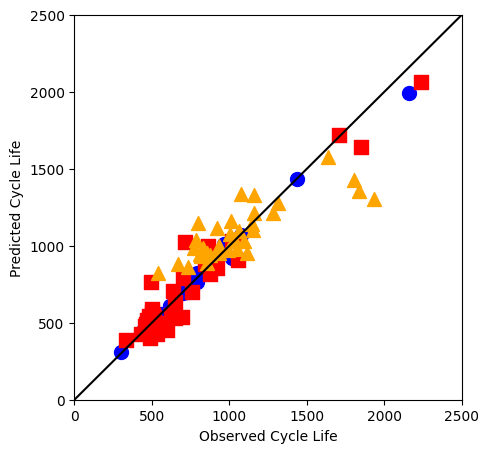

In [15]:
testALL(model)

################################################################################

# Repeat using only the first 60 cycles

################################################################################

In [16]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData-60Cycles.csv')

# Scale target Battery life By log 10
Dataset['cell_life']=np.log10(Dataset['cell_life'])

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']

In [17]:
#Load discharge capacity data
train_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Train.pt')
test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Test.pt')
secondary_test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Secondary_Test.pt')

train_Qdlin = train_Qdlin[:,:60,:]
test_Qdlin = test_Qdlin[:,:60,:]
secondary_test_Qdlin = secondary_test_Qdlin[:,:60,:]

train_Qdlin = torch.permute(train_Qdlin, (0, 2, 1))
test_Qdlin = torch.permute(test_Qdlin, (0, 2, 1))
secondary_test_Qdlin = torch.permute(secondary_test_Qdlin, (0, 2, 1))

print(train_Qdlin.std(),train_Qdlin.mean())
print(test_Qdlin.std(),test_Qdlin.mean())
print(secondary_test_Qdlin.std(),secondary_test_Qdlin.mean())

print(train_Qdlin.shape)
print(test_Qdlin.shape)
print(secondary_test_Qdlin.shape)

tensor(1.1621) tensor(-0.8226)
tensor(1.0245) tensor(-0.7291)
tensor(0.5661) tensor(-0.3582)
torch.Size([41, 99, 60])
torch.Size([42, 99, 60])
torch.Size([40, 99, 60])


In [18]:
y_train=Training_Data[target_features].to_numpy()
y_test=Testing_Data[target_features].to_numpy()
y_sec=Secondary_Data[target_features].to_numpy()

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_sec = torch.tensor(y_sec)

y_train_mean = torch.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean
y_sec = y_sec - y_train_mean
#Be sure to add y_train_mean and 10** All results

In [19]:
torch.set_default_dtype(torch.float64)

In [20]:
train_Dataset = CustomDataset(train_Qdlin,y_train)
test_Dataset = CustomDataset(test_Qdlin,y_test)
secondary_test_Dataset = CustomDataset(secondary_test_Qdlin,y_sec)

train_Qdlin_loader = DataLoader(train_Dataset, batch_size=41, shuffle=True)
test_Qdlin_loader = DataLoader(test_Dataset, batch_size=42, shuffle=True)
secondary_test_Qdlin_loader = DataLoader(secondary_test_Dataset, batch_size=40, shuffle=True)

# Hyper-parameters

In [21]:
hidden_size = 128 
hidden_size2 = 256
num_layers = 1
dropout = .2
num_dense_neurons= 32

epochs = 1500
lr = 0.0001
weight_decay = 0.001

In [22]:
input_size=train_Qdlin.shape[2] #FEATURES
num_cycles=train_Qdlin.shape[1] #TIMESTEPS(Cycles)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


# Train & Test

In [23]:
criterion=nn.MSELoss()
model=LSTMRNN(input_size, hidden_size, hidden_size2, num_layers,dropout, num_dense_neurons)
optimizer=optim.Adam(model.parameters(),weight_decay=weight_decay, lr=lr)
model = model.to(device)
model = train(model,train_Qdlin_loader,criterion,optimizer,epochs,device)

torch.Size([41, 99, 60])
torch.Size([41, 99, 128])
torch.Size([41, 99, 256])
torch.Size([41, 256])
-- 0 -epoch--RMSE--  336.980383494875
-- 100 -epoch--RMSE--  196.49968004765717
-- 200 -epoch--RMSE--  131.85181522835035
-- 300 -epoch--RMSE--  94.58795444219324
-- 400 -epoch--RMSE--  76.86408492435504
-- 500 -epoch--RMSE--  67.48869808237947
-- 600 -epoch--RMSE--  59.78603669183872
-- 700 -epoch--RMSE--  55.16332345419964
-- 800 -epoch--RMSE--  51.36938232273512
-- 900 -epoch--RMSE--  73.4541346743964
-- 1000 -epoch--RMSE--  45.78932029781354
-- 1100 -epoch--RMSE--  42.95469577445578
-- 1200 -epoch--RMSE--  42.12922462716005
-- 1300 -epoch--RMSE--  40.427754874988594
-- 1400 -epoch--RMSE--  39.86140423345441


38.01373387863486 ---RMSE---Train
2.3313041187454475 ---MPE---Train
316.0990761642964 ---RMSE---Test
18.217437737433208 ---MPE---Test
220.24435392175144 ---RMSE---Test Secondary
17.310061081728975 ---MPE---Test Secondary


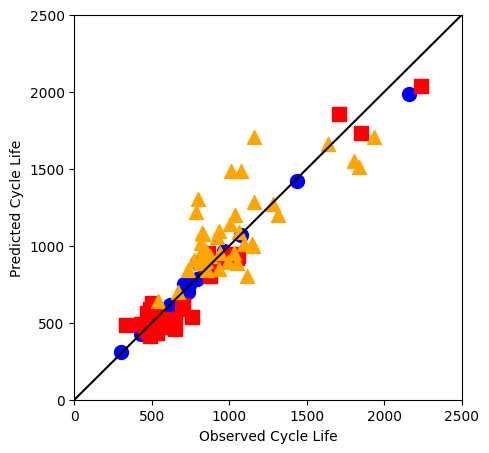

In [24]:
testALL(model)

################################################################################

# Repeat using only the first 40 cycles

################################################################################

In [25]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData-40Cycles.csv')

# Scale target Battery life By log 10
Dataset['cell_life']=np.log10(Dataset['cell_life'])

numBat1=41
numBat2=43
numBat3=40
numBat=124
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
test_edited_ind = np.delete(test_ind, 21) # Remove battery 
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat)

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']


In [26]:
#Load discharge capacity data
train_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Train.pt')
test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Test.pt')
secondary_test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Secondary_Test.pt')

train_Qdlin = train_Qdlin[:,:40,:]
test_Qdlin = test_Qdlin[:,:40,:]
secondary_test_Qdlin = secondary_test_Qdlin[:,:40,:]

train_Qdlin = torch.permute(train_Qdlin, (0, 2, 1))
test_Qdlin = torch.permute(test_Qdlin, (0, 2, 1))
secondary_test_Qdlin = torch.permute(secondary_test_Qdlin, (0, 2, 1))

print(train_Qdlin.std(),train_Qdlin.mean())
print(test_Qdlin.std(),test_Qdlin.mean())
print(secondary_test_Qdlin.std(),secondary_test_Qdlin.mean())

print(train_Qdlin.shape)
print(test_Qdlin.shape)
print(secondary_test_Qdlin.shape)

tensor(1.1242) tensor(-0.6322)
tensor(0.9673) tensor(-0.5410)
tensor(0.5148) tensor(-0.2270)
torch.Size([41, 99, 40])
torch.Size([42, 99, 40])
torch.Size([40, 99, 40])


In [27]:
y_train=Training_Data[target_features].to_numpy()
y_test=Testing_Data[target_features].to_numpy()
y_sec=Secondary_Data[target_features].to_numpy()

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_sec = torch.tensor(y_sec)

y_train_mean = torch.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean
y_sec = y_sec - y_train_mean
#Be sure to add y_train_mean and 10** All results

In [28]:
torch.set_default_dtype(torch.float64)

In [29]:
train_Dataset = CustomDataset(train_Qdlin,y_train)
test_Dataset = CustomDataset(test_Qdlin,y_test)
secondary_test_Dataset = CustomDataset(secondary_test_Qdlin,y_sec)

train_Qdlin_loader = DataLoader(train_Dataset, batch_size=41, shuffle=True)
test_Qdlin_loader = DataLoader(test_Dataset, batch_size=42, shuffle=True)
secondary_test_Qdlin_loader = DataLoader(secondary_test_Dataset, batch_size=40, shuffle=True)

# Hyper-parameters

In [30]:
hidden_size = 128 
hidden_size2 = 256
num_layers = 1
dropout = .2
num_dense_neurons= 32

epochs = 1500
lr = 0.0001
weight_decay = 0.001

In [31]:
input_size=train_Qdlin.shape[2] #FEATURES
num_cycles=train_Qdlin.shape[1] #TIMESTEPS(Cycles)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


# Train & Test

In [32]:
criterion=nn.MSELoss()
model=LSTMRNN(input_size, hidden_size, hidden_size2, num_layers,dropout, num_dense_neurons)
optimizer=optim.Adam(model.parameters(),weight_decay=weight_decay, lr=lr)
model = model.to(device)
model = train(model,train_Qdlin_loader,criterion,optimizer,epochs,device)

torch.Size([41, 99, 40])
torch.Size([41, 99, 128])
torch.Size([41, 99, 256])
torch.Size([41, 256])
-- 0 -epoch--RMSE--  387.82345400475833
-- 100 -epoch--RMSE--  231.02371741920018
-- 200 -epoch--RMSE--  161.34816570365788
-- 300 -epoch--RMSE--  117.59941719377098
-- 400 -epoch--RMSE--  97.1692954897887
-- 500 -epoch--RMSE--  83.92618162525962
-- 600 -epoch--RMSE--  75.16752533875761
-- 700 -epoch--RMSE--  70.29143260286499
-- 800 -epoch--RMSE--  65.6664380335742
-- 900 -epoch--RMSE--  60.81222405996365
-- 1000 -epoch--RMSE--  57.321212439421764
-- 1100 -epoch--RMSE--  55.91336577830687
-- 1200 -epoch--RMSE--  52.41775168707287
-- 1300 -epoch--RMSE--  50.814699551522054
-- 1400 -epoch--RMSE--  50.270284811912354


49.102041404710235 ---RMSE---Train
3.659195071122881 ---MPE---Train
127.33127071883881 ---RMSE---Test
12.715604580950206 ---MPE---Test
218.38383932885077 ---RMSE---Test Secondary
17.186805985683208 ---MPE---Test Secondary


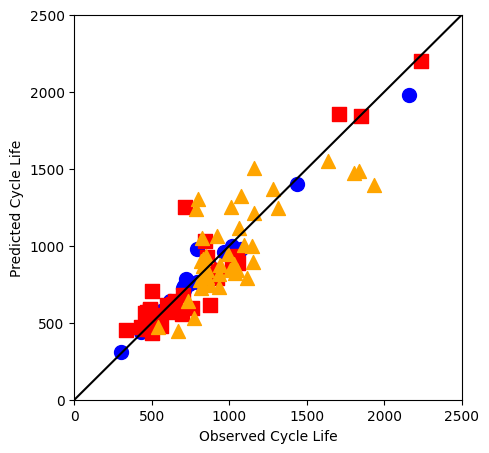

In [33]:
testALL(model)

################################################################################

# Repeat using only the first 20 cycles

################################################################################

In [34]:
#Load tabular data
Dataset=pd.read_csv(r'data/TabularSummaryBatteryData-20Cycles.csv')

# Scale target Battery life By log 10
Dataset['cell_life']=np.log10(Dataset['cell_life'])

Training_Data=Dataset.iloc[train_ind]
Testing_Data=Dataset.iloc[test_edited_ind]
Secondary_Data=Dataset.iloc[secondary_test_ind]

#choosing model features According to table 1
target_features=['cell_life']

In [35]:
#Load discharge capacity data
train_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Train.pt')
test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Test.pt')
secondary_test_Qdlin=torch.load(r'data/DischargeCapacity-InterpolatedData_Secondary_Test.pt')

train_Qdlin = train_Qdlin[:,:20,:]
test_Qdlin = test_Qdlin[:,:20,:]
secondary_test_Qdlin = secondary_test_Qdlin[:,:20,:]

train_Qdlin = torch.permute(train_Qdlin, (0, 2, 1))
test_Qdlin = torch.permute(test_Qdlin, (0, 2, 1))
secondary_test_Qdlin = torch.permute(secondary_test_Qdlin, (0, 2, 1))

print(train_Qdlin.std(),train_Qdlin.mean())
print(test_Qdlin.std(),test_Qdlin.mean())
print(secondary_test_Qdlin.std(),secondary_test_Qdlin.mean())

print(train_Qdlin.shape)
print(test_Qdlin.shape)
print(secondary_test_Qdlin.shape)

tensor(0.0264) tensor(-0.0102)
tensor(0.0276) tensor(-0.0079)
tensor(0.0151) tensor(0.0023)
torch.Size([41, 99, 20])
torch.Size([42, 99, 20])
torch.Size([40, 99, 20])


In [36]:
y_train=Training_Data[target_features].to_numpy()
y_test=Testing_Data[target_features].to_numpy()
y_sec=Secondary_Data[target_features].to_numpy()

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_sec = torch.tensor(y_sec)

y_train_mean = torch.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean
y_sec = y_sec - y_train_mean
#Be sure to add y_train_mean and 10** All results

In [37]:
torch.set_default_dtype(torch.float64)

In [38]:
train_Dataset = CustomDataset(train_Qdlin,y_train)
test_Dataset = CustomDataset(test_Qdlin,y_test)
secondary_test_Dataset = CustomDataset(secondary_test_Qdlin,y_sec)

train_Qdlin_loader = DataLoader(train_Dataset, batch_size=41, shuffle=True)
test_Qdlin_loader = DataLoader(test_Dataset, batch_size=42, shuffle=True)
secondary_test_Qdlin_loader = DataLoader(secondary_test_Dataset, batch_size=40, shuffle=True)

# Hyper-parameters

In [39]:
hidden_size = 128 
hidden_size2 = 256
num_layers = 1
dropout = .2
num_dense_neurons= 32

epochs = 1500
lr = 0.0001
weight_decay = 0.001

In [40]:
input_size=train_Qdlin.shape[2] #FEATURES
num_cycles=train_Qdlin.shape[1] #TIMESTEPS(Cycles)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


# Train & Test

In [41]:
criterion=nn.MSELoss()
model=LSTMRNN(input_size, hidden_size, hidden_size2, num_layers,dropout, num_dense_neurons)
optimizer=optim.Adam(model.parameters(),weight_decay=weight_decay, lr=lr)
model = model.to(device)
model = train(model,train_Qdlin_loader,criterion,optimizer,epochs,device)

torch.Size([41, 99, 20])
torch.Size([41, 99, 128])
torch.Size([41, 99, 256])
torch.Size([41, 256])
-- 0 -epoch--RMSE--  406.70545410406277
-- 100 -epoch--RMSE--  336.972133521836
-- 200 -epoch--RMSE--  328.768479356721
-- 300 -epoch--RMSE--  327.93505631874046
-- 400 -epoch--RMSE--  327.40083276683
-- 500 -epoch--RMSE--  327.05558389324045
-- 600 -epoch--RMSE--  326.74161711126993
-- 700 -epoch--RMSE--  326.34575942098985
-- 800 -epoch--RMSE--  325.98953696199857
-- 900 -epoch--RMSE--  325.54888849489254
-- 1000 -epoch--RMSE--  324.843735394601
-- 1100 -epoch--RMSE--  322.77074457560974
-- 1200 -epoch--RMSE--  303.35357576383547
-- 1300 -epoch--RMSE--  292.0158526953501
-- 1400 -epoch--RMSE--  282.4533127902077


271.0041192484168 ---RMSE---Train
23.29048447672083 ---MPE---Train
352.45137838225827 ---RMSE---Test
25.586501646404276 ---MPE---Test
281.1825573607863 ---RMSE---Test Secondary
12.95269215648411 ---MPE---Test Secondary


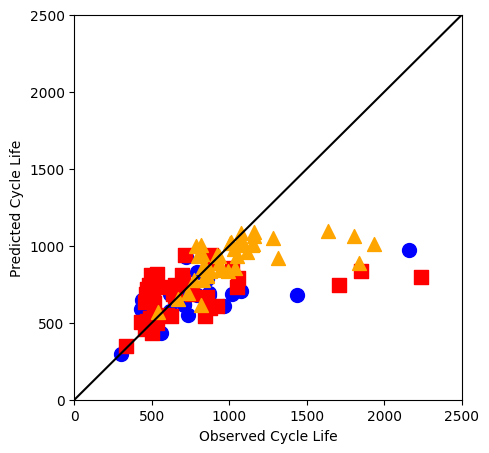

In [42]:
testALL(model)

In [43]:
pd.DataFrame({"Model":[ "LSTM 100 cycles", "LSTM 60 cycles","LSTM 40 cycles","LSTM 20 cycles"],
      "RMSE - Train": [RMSE[0],RMSE[3],RMSE[6],RMSE[9]],
      "RMSE - Test": [RMSE[1],RMSE[4],RMSE[7],RMSE[10]],
      "RMSE - Secondary test": [RMSE[2],RMSE[5],RMSE[8],RMSE[11]],
      "MPE - Train": [MPE[0],MPE[3],MPE[6],MPE[9]],
      "MPE - Test": [MPE[1],MPE[4],MPE[7],MPE[10]],
      "MPE - Secondary test": [MPE[2],MPE[5],MPE[8],MPE[11]]})  

,Model,RMSE - Train,RMSE - Test,RMSE - Secondary test,MPE - Train,MPE - Test,MPE - Secondary test
0,LSTM 100 cycles,35,101,193,1,11,14
1,LSTM 60 cycles,38,316,220,2,18,17
2,LSTM 40 cycles,49,127,218,3,12,17
3,LSTM 20 cycles,271,352,281,23,25,12


Xu, P., & Lu, Y. (2022). Predicting Li-ion Battery Cycle Life with LSTM RNN. arXiv preprint arxiv.org/abs/2207.03687	